<a href="https://colab.research.google.com/github/yuya1951/deeplarning/blob/main/grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jul 17 06:24:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive")

In [ ]:
!pip install keras==2.2.5
!pip install tensorflow==1.14.0
#!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==1.14.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==1.14.0


In [ ]:
!python vgg16.py

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)

    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

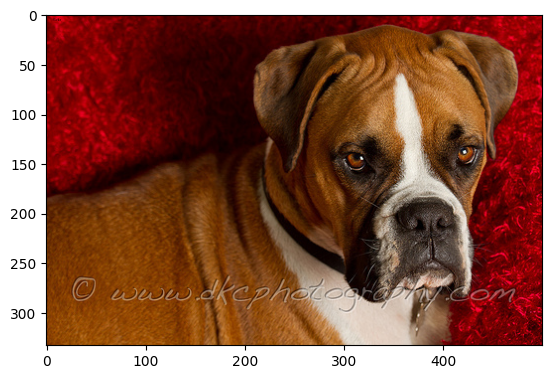

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

orig_img = np.array(load_img('./boxer_21.jpg'),dtype=np.uint8)
plt.imshow(orig_img)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


./boxer_21.jpg


/content/gdrive/MyDrive/grad_cam4.py:58: RuntimeWarning: invalid value encountered in true_divide
  alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))


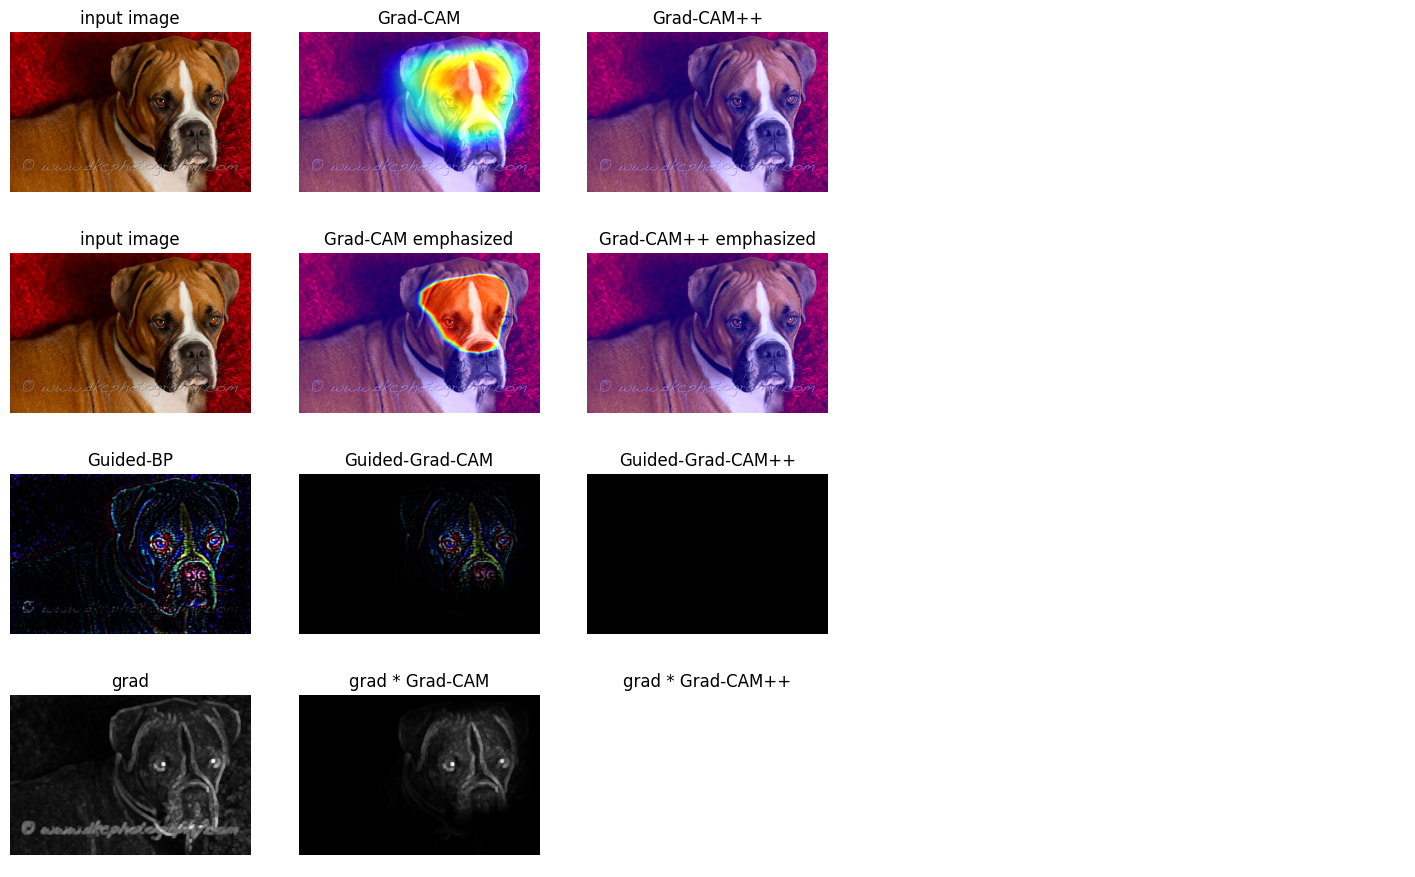

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import cv2
import numpy as np
from grad_cam4 import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

def build_VGG16():
    return VGG16(include_top=True, weights='imagenet')

model = tf.keras.models.load_model('./model_and_weight.h5')
layer_name = 'block5_conv3'

img_path = './boxer_21.jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

predictions = model.predict(img_array)
#top = decode_predictions(predictions, top=5)[0]
print(img_path)
#print("class activation map for:",top[0])

grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

#score_cam=ScoreCam(model,img_array,layer_name)
#score_cam_superimposed = superimpose(img_path, score_cam)
#score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

#faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
#faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
#faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

guided_model = build_guided_model(build_VGG16)
saliency = GuidedBackPropagation(guided_model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

#score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
#guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

#faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
#guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]

img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  # 画像の勾配を取得
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)  # 太らせる処理
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

grad_times_grad_cam = grad * grad_cam_resized
grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
#grad_times_score_cam = grad * score_cam_resized
#grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 11))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")
ax[0,2].imshow(grad_cam_plus_plus_superimposed)
ax[0,2].set_title("Grad-CAM++")
#ax[0,3].imshow(score_cam_superimposed)
#ax[0,3].set_title("Score-CAM")
#ax[0,4].imshow(faster_score_cam_superimposed)
#ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_emphasized)
ax[1,1].set_title("Grad-CAM emphasized")
ax[1,2].imshow(grad_cam_plus_plus_emphasized)
ax[1,2].set_title("Grad-CAM++ emphasized")
#ax[1,3].imshow(score_cam_emphasized)
#ax[1,3].set_title("Score-CAM emphasized")
#ax[1,4].imshow(faster_score_cam_emphasized)
#ax[1,4].set_title("Faster-Score-CAM emphasized")
ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
ax[2,2].imshow(guided_grad_cam_plus_plus)
ax[2,2].set_title("Guided-Grad-CAM++")
#ax[2,3].imshow(guided_score_cam)
#ax[2,3].set_title("Guided-Score-CAM")
#ax[2,4].imshow(guided_faster_score_cam)
#ax[2,4].set_title("Guided-Faster-Score-CAM")
ax[3,0].imshow(grad, 'gray')
ax[3,0].set_title("grad")
ax[3,1].imshow(grad_times_grad_cam, 'gray')
ax[3,1].set_title("grad * Grad-CAM")
ax[3,2].imshow(grad_times_grad_cam_plus_plus, 'gray')
ax[3,2].set_title("grad * Grad-CAM++")
#ax[3,3].imshow(grad_times_score_cam, 'gray')
#ax[3,3].set_title("grad * Score-CAM")
#ax[3,4].imshow(grad_times_faster_score_cam, 'gray')
#ax[3,4].set_title("grad * Faster-Score-CAM")
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
plt.show()